In [2]:
import torch
from torch.utils.data import DataLoader
import os
import pandas as pd
from work.utils.dataset import PandasDataset, RemovePenMarkAlbumentations
from work.utils.models import EfficientNet
from work.utils.metrics import evaluation
import albumentations
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
output_dimensions = 5
data_dir = '../../dataset'
images_dir = os.path.join(data_dir, 'tiles')
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
df_test = pd.read_csv(f"../data/test.csv")
backbone_model = 'efficientnet-b0'
pretrained_model = {
    backbone_model: 'models/efficientnet-b0-08094119.pth'
}

In [4]:
print("Cuda", device)

Cuda cuda


In [5]:
dataloader = DataLoader(
    PandasDataset(images_dir, df_test, transforms=None, normalize=True),
    batch_size=2,
    shuffle=False,
)

In [6]:
model_noise = EfficientNet(
    backbone=backbone_model,
    output_dimensions=output_dimensions,
    pre_trained_model=pretrained_model
)
model_noise.to(device).load_state_dict(
    torch.load(
        "models/with-noise.pth",
        weights_only=True,
        map_location=device
    )
)

model_without_noise = EfficientNet(
    backbone=backbone_model,
    output_dimensions=output_dimensions,
    pre_trained_model=pretrained_model
)
model_without_noise.to(device).load_state_dict(
    torch.load(
        "models/without-noise-rgb.pth",
        weights_only=True
    )
)
response_noise = evaluation(model_noise, dataloader, device)
print("noise", response_noise[0])

Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0


100%|██████████| 796/796 [01:51<00:00,  7.11it/s]


noise {'val_acc': 63.06532663316583, 'kappa': 0.858868178544851, 'iq': {'mean': tensor(0.8585), 'std': tensor(0.0096), 'quantile': tensor([0.8424, 0.8737])}}


In [7]:
response_without_noise = evaluation(model_without_noise, dataloader, device)
print("without noise", response_without_noise[0])


100%|██████████| 796/796 [01:47<00:00,  7.42it/s]


without noise {'val_acc': 63.06532663316583, 'kappa': 0.8661488473083696, 'iq': {'mean': tensor(0.8661), 'std': tensor(0.0089), 'quantile': tensor([0.8511, 0.8808])}}


In [8]:
model_fill_patches = EfficientNet(
    backbone=backbone_model,
    output_dimensions=output_dimensions,
    pre_trained_model=pretrained_model
)
model_fill_patches.to(device).load_state_dict(
    torch.load(
        "models/fill-patches.pth",
        weights_only=True
    )
)

transforms = albumentations.Compose([
    RemovePenMarkAlbumentations(),
])


dataloader_fill = DataLoader(
    PandasDataset(images_dir, df_test, transforms=transforms, normalize=True),
    batch_size=2,
    shuffle=False,
)

Loaded pretrained weights for efficientnet-b0


In [9]:
response_fill_patches = evaluation(model_fill_patches, dataloader_fill, device)
print("fill patches", response_fill_patches[0])

100%|██████████| 796/796 [04:18<00:00,  3.08it/s]


fill patches {'val_acc': 55.904522613065325, 'kappa': 0.8200995760447468, 'iq': {'mean': tensor(0.8204), 'std': tensor(0.0107), 'quantile': tensor([0.8021, 0.8371])}}


# Confusion Matrix

In [10]:
cm_0 = confusion_matrix(response_noise[1][1], response_noise[1][0])
cm_1 = confusion_matrix(response_without_noise[1][1], response_without_noise[1][0])
cm_2 = confusion_matrix(response_fill_patches[1][1], response_fill_patches[1][0])

In [11]:
# print(cm_0, "\n", cm_1, "\n")

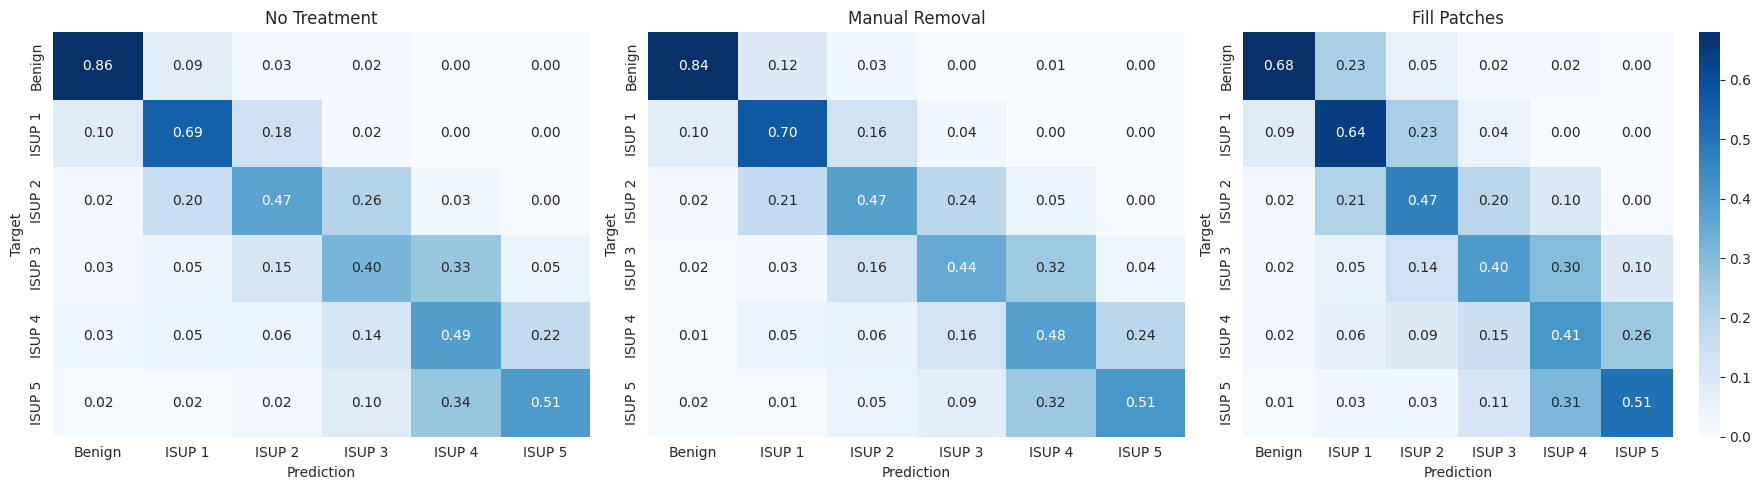

In [15]:
fig = plt.figure(figsize=(18, 5))
gs = fig.add_gridspec(1, 3)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])

# Labels
labels = ["Benign", "ISUP 1", "ISUP 2", "ISUP 3", "ISUP 4", "ISUP 5"]

sns.heatmap(cm_0/cm_0.sum(axis=1, keepdims=True), fmt=".2f", annot=True, cmap="Blues", xticklabels=labels, yticklabels=labels, ax=ax0, cbar=False)
ax0.set_xlabel("Prediction")
ax0.set_ylabel("Target")
ax0.set_title("No Treatment")

sns.heatmap(cm_1/cm_1.sum(axis=1, keepdims=True), fmt=".2f", annot=True, cmap="Blues", xticklabels=labels, yticklabels=labels, ax=ax1, cbar=False)
ax1.set_xlabel("Prediction")
ax1.set_ylabel("Target")
ax1.set_title("Manual Removal")

sns.heatmap(cm_2/cm_2.sum(axis=1, keepdims=True), fmt=".2f", annot=True, cmap="Blues", xticklabels=labels, yticklabels=labels, ax=ax2)
ax2.set_xlabel("Prediction")
ax2.set_ylabel("Target")
ax2.set_title("Fill Patches")

plt.tight_layout()

plt.savefig("confusion_matrix.png", dpi=300)
plt.show()